# Project: Marketing Email Campaign---Is there any way to improve click through rate in email marketing campaigns?

### Key Words: Segment users, EDA, XGBoost, Roc curve, Probability threshold, Classification Report, Precision Score, Recall Score, Feature Importance, A/B testing

### Situation:
In this mock project, I assume the marketing team launched an email campaign. Previously they send the marketing email to all of their customers. The click throught rate is low. From the marketing team perspective, a success is if the user clicks on the link inside the email.


### Task:
Assume I was tasked to propose solution to improve click through rate in future marketing email campaign. 


### Action and Result:
I will perform EDA, stastistical analysis, data visualization and develop machine learning model in this task. Finally based on these analysis,I will present data-driven solutions. And to test if the solutions is effective or not, A/B testing may also needed. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning model related
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2

# model algorithams
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier


%matplotlib inline
plt.tight_layout()

<Figure size 432x288 with 0 Axes>

### Preparing Data

In [2]:
# read the email table and make email_id as index
email = pd.read_csv('C:/Users/xiaoj/Desktop/level 20 interview/email/email_table.csv',index_col = 'email_id')
email.head()

,email_text,email_version,hour,weekday,user_country,user_past_purchases
email_id,,,,,,
85120,short_email,personalized,2,Sunday,US,5
966622,long_email,personalized,12,Sunday,UK,2
777221,long_email,personalized,11,Wednesday,US,2
493711,short_email,generic,6,Monday,UK,1
106887,long_email,generic,14,Monday,US,6


In [3]:
# rename long column names to shorter and understandable ones to make it easier to manipulation
email.rename(columns = {'email_id':'id', 'email_text':'is_short', 'email_version':'is_personalized','user_country':'country', 'user_past_purchases':'purchases'},inplace=True)
email.head()

,is_short,is_personalized,hour,weekday,country,purchases
email_id,,,,,,
85120,short_email,personalized,2,Sunday,US,5
966622,long_email,personalized,12,Sunday,UK,2
777221,long_email,personalized,11,Wednesday,US,2
493711,short_email,generic,6,Monday,UK,1
106887,long_email,generic,14,Monday,US,6


In [157]:
# check for duplicates
pd.read_csv('C:/Users/xiaoj/Desktop/level 20 interview/email/email_table.csv').duplicated().sum()

0

In [158]:
email.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 85120 to 348333
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   is_short         100000 non-null  object
 1   is_personalized  100000 non-null  object
 2   hour             100000 non-null  int64 
 3   weekday          100000 non-null  object
 4   country          100000 non-null  object
 5   purchases        100000 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 5.3+ MB


From the data information, it can be easily found that there are no missing values in the dataset. And it includes 6 features, only two are numerical and the others are categorical. So I will firstly check the statistical information and types, respectively。

In [159]:
# Check the numerical features, if there are outliers
email.describe()

,hour,purchases
count,100000.000000,100000.00000
mean,9.059300,3.87845
std,4.439637,3.19611
min,1.000000,0.00000
25%,6.000000,1.00000
50%,9.000000,3.00000
75%,12.000000,6.00000
max,24.000000,22.00000


In [160]:
#check the categories in categorical features
[email[x].nunique() for x in ['is_short','is_personalized','weekday','country']]

[2, 2, 7, 4]

From the above data, it can be found that there are no outlier and category data is also reasonable.

In [4]:
# read the "open" and "click" data in another two tables
open = pd.read_csv('C:/Users/xiaoj/Desktop/level 20 interview/email/email_opened_table.csv')
open.head()

,email_id
0,284534
1,609056
2,220820
3,905936
4,164034


In [5]:
click = pd.read_csv('C:/Users/xiaoj/Desktop/level 20 interview/email/link_clicked_table.csv')
click.head()

,email_id
0,609056
1,870980
2,935124
3,158501
4,177561


To concatenate the values in open and click table into the email table. I added two new features in 'email' called 'open' and "click, which showed the customer's reactions to the link after they received the email.


### What percentage of users opened the email and clicked the link, respectively?

For simplicity, Here I define the open rate are the users open the email divided by the total users we send emails to, the click through rate is those who clicked the link in the email divided by the total user numbers we send out.

In [6]:
# add "open" features in email
email['open'] = 0
email.loc[open['email_id'],'open'] = 1
email['open'].value_counts(normalize = True)
print("The ratio of opening the email is:", email['open'].value_counts(normalize = True)[1])

# add "click features in email
email['click']=0
email.loc[click['email_id'],'click'] = 1
email['click'].value_counts(normalize=True)
print("The ratio of clicking the email is:", email['click'].value_counts(normalize = True)[1])

The ratio of opening the email is: 0.10345
The ratio of clicking the email is: 0.02119


It can be easily found that 10.345 %(opened + clicked)customers opened the email, and 2.119 % customers clicked the link.

In [164]:
email.sample(5)

,is_short,is_personalized,hour,weekday,country,purchases,open,click
email_id,,,,,,,,
622053,long_email,personalized,13,Tuesday,US,1,0,0
213458,long_email,personalized,6,Thursday,US,3,0,0
528622,long_email,personalized,12,Tuesday,US,4,0,0
132823,long_email,generic,10,Wednesday,UK,0,0,0
738295,short_email,generic,2,Friday,US,2,1,1


In [7]:
# since people who click the link in the mail must open the email, so I produce another table with open and click feature merged
email1 = email.drop(columns = ['open','click']).copy()
email1['reaction'] = 'received'

# according to the other two tables, specify the operations customers did 
email1.loc[open['email_id'],'reaction'] = 'opened'
email1.loc[click['email_id'],'reaction'] = 'clicked'

email1.head()

,is_short,is_personalized,hour,weekday,country,purchases,reaction
email_id,,,,,,,
85120,short_email,personalized,2,Sunday,US,5,received
966622,long_email,personalized,12,Sunday,UK,2,clicked
777221,long_email,personalized,11,Wednesday,US,2,received
493711,short_email,generic,6,Monday,UK,1,received
106887,long_email,generic,14,Monday,US,6,received


### Stastistical Analysis

#### Distribution of Target

In [168]:
click_count = pd.DataFrame(email['click'].value_counts())
click_count

,click
0,97881
1,2119


In [169]:
open_count = pd.DataFrame(email['open'].value_counts())
open_count

,open
0,89655
1,10345


It can be seen that the data is imbalanced dataset since the open or click are only minorties of the dataset.

<a id='explorepattern'></a>
### Explore Correlation

Text(0.5, 1.0, 'Correlation Heatmap')

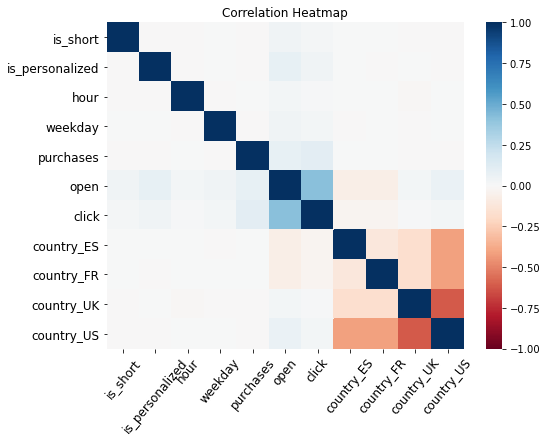

In [8]:
# make a copy of original data since change may be introduced to the table
X = email.copy()

# I cut the 24 hours into 4 parts to make it easier to be categoried and analyzed
X["hour"] = pd.cut(email['hour'],bins = [0,9,13,18,24], labels=["morning",'workhour1',"workhour2",'evening'])

# encode the category features
X['hour'] = LabelEncoder().fit_transform(X['hour'])
X['is_short'] = LabelEncoder().fit_transform(X['is_short'])
X['is_personalized'] = LabelEncoder().fit_transform(X['is_personalized'])
X['weekday'] = LabelEncoder().fit_transform(X['weekday'])

# I use a differnt function to transfer country into number since country is a key factor
X = pd.get_dummies(X,columns=['country'])


# draw the heatmap to get the correlationship between features
plt.figure(figsize = (8, 6))
s = sns.heatmap(X.corr(),cmap = 'RdBu',vmin = -1, vmax = 1,center = 0)
s.set_yticklabels(s.get_yticklabels(), rotation = 0, fontsize = 12)
s.set_xticklabels(s.get_xticklabels(), rotation = 50, fontsize = 12)
plt.title("Correlation Heatmap")

In [9]:
# print the correlation between features and target 
X.corr()['click'].sort_values(ascending = False)

click              1.000000
open               0.421750
purchases          0.105445
is_personalized    0.042208
country_US         0.027012
weekday            0.025308
is_short           0.018519
hour               0.013156
country_UK         0.012077
country_ES        -0.029716
country_FR        -0.030511
Name: click, dtype: float64

In [22]:
from scipy.stats import pearsonr

r, p_value  =  pearsonr(x=email['click'], y=email['open'])

# print results
print('Pearson correlation of open and click is', r1)
print('Pearson p-value: ', p_value1)

Pearson correlation of open and click is 0.4217500240716455
Pearson p-value:  0.0


Heatmap shows the correlations between each features. Whe it is blue,it suggests that they are positively correlated, wheras when they are red, they are negative correlated. Based on the heatmap, we can see:
- click and open has a very positive strong associated relationship;
- Some country, such as ES and FR has negative effect on the open and click, while US and UK has position effect;
- Purchases features has some positive linear effect on the open and click output.

<a id='chi2'></a>
### Chi2-test
Chi-square test can be performed to find the relatively associate relationship between categories features and output

In [175]:
# define the x and y for the chi2-test
x = X.drop(columns=['click',"purchases"])
y = X['click']

# chi2-test
chi2score,pvalue = chi2(x,y)
feature_chiscore = pd.DataFrame({'chi2score':chi2score,"p-value": pvalue},index = X.drop(columns=['click',"purchases"]).columns)
feature_chiscore.sort_values(by='chi2score',ascending=False)

,chi2score,p-value
open,15947.211239,0.000000e+00
is_personalized,89.446479,3.150472e-21
weekday,85.093172,2.846317e-20
country_FR,83.787543,5.509086e-20
country_ES,79.503671,4.813301e-19
country_US,29.114098,6.823860e-08
is_short,17.241715,3.291296e-05
country_UK,11.677349,6.326561e-04
hour,6.513384,1.070656e-02


In [176]:
# define the x and y for the chi2-test
x = X.drop(columns=['open',"click","purchases"])
y = X['open']

# chi2-test
chi2score,pvalue = chi2(x,y)
feature_chiscore = pd.DataFrame({'chi2score':chi2score,"p-value": pvalue},index = X.drop(columns=['click',"open","purchases"]).columns)
feature_chiscore.sort_values(by='chi2score',ascending=False)

,chi2score,p-value
country_ES,444.593717,1.083149e-98
country_FR,425.409927,1.621546e-94
is_personalized,317.104038,6.190323e-71
weekday,229.291534,8.508405e-52
country_US,157.092431,4.885991e-36
is_short,82.560581,1.024805e-19
country_UK,60.074405,9.133842e-15
hour,35.236185,2.920464e-09


From the **chi2** test, it can be fount top 3 important factor:
- If the email open has absolutely great effect on the click rate;
- The 4 countries has different associated relationship with open rate; ES and FR has relatively larger effect;
- if the email personalized also show some influence on the open and click;

In [179]:
# define functions that can be generally applied to the various features when chek their influence on click rate
def final_ratio(data):
    return data['reaction'].value_counts(normalize = True)

def feature_plot(feature):
    feature_inf = email1.groupby(feature).apply(final_ratio)
    feature_inf.loc[:,['opened','clicked']].plot(kind='bar')
    plt.ylabel('Open & Click Ratio')
    plt.xlabel(feature)
    plt.xticks(rotation=0)
    plt.title('Click Ratio vs. {}'.format(feature))
    return feature_inf.sort_values(by=['clicked'],ascending = False)


### Email personalized vs. Customers' reactions

reaction,received,opened,clicked
is_personalized,,,
personalized,0.871864,0.100842,0.027294
generic,0.920034,0.064829,0.015137


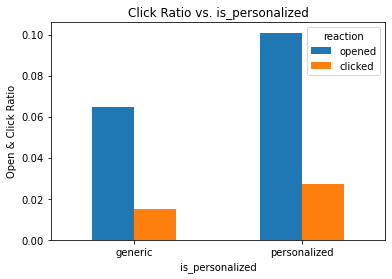

In [180]:
# check if personlized email will produce more click rate
feature_plot('is_personalized')

### Email length vs. Customers' reactions

reaction,received,opened,clicked
is_short,,,
short_email,0.883698,0.092430,0.023872
long_email,0.908266,0.073196,0.018538


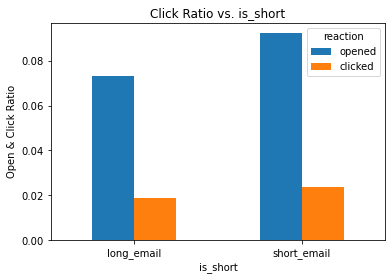

In [181]:
# check if 'email text' is short has influence on final click rate
feature_plot('is_short')

It is easily to understand that personalized emails are more easier to be opened and clicked. the lendth of email has not much influence on the open and click rate.

In [11]:
z= email.copy()
pos = z[z['click']==1].drop(columns = 'click')
neg = z[z['click']==0].drop(columns = 'click')
pos.head()

,is_short,is_personalized,hour,weekday,country,purchases,open
email_id,,,,,,,
966622,long_email,personalized,12,Sunday,UK,2,1
849,short_email,generic,16,Tuesday,US,5,1
721625,short_email,personalized,6,Thursday,US,7,1
477022,long_email,generic,7,Thursday,UK,4,1
135729,long_email,personalized,12,Monday,US,1,1


In [16]:
z = email.copy()
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
z['purchases'] = scaler.fit_transform(z[['purchases']])
z["hour"] = pd.cut(email['hour'],bins = [0,9,13,18,24], labels=["morning",'workhour1',"workhour2",'evening'])

# labelencoder the categorical fields inside the table
z['hour'] = LabelEncoder().fit_transform(z['hour'])
z['is_short'] = LabelEncoder().fit_transform(z['is_short'])
z['is_personalized'] = LabelEncoder().fit_transform(z['is_personalized'])
z['weekday'] = LabelEncoder().fit_transform(z['weekday'])
z['weekday'] = (z['weekday']>=4).astype(int)

z = pd.get_dummies(z,columns=['country'])
z.head()

,is_short,is_personalized,hour,weekday,purchases,open,click,country_ES,country_FR,country_UK,country_US
email_id,,,,,,,,,,,
85120,1,1,1,0,0.227273,0,0,0,0,0,1
966622,0,1,2,0,0.090909,1,1,0,0,1,0
777221,0,1,2,1,0.090909,0,0,0,0,0,1
493711,1,0,1,0,0.045455,0,0,0,0,1,0
106887,0,0,3,0,0.272727,0,0,0,0,0,1


In [17]:
pos = z[z['click']==1].drop(columns = ['click','open'])
neg = z[z['click']==0].drop(columns = ['click','open'])
pos.head()

,is_short,is_personalized,hour,weekday,purchases,country_ES,country_FR,country_UK,country_US
email_id,,,,,,,,,
966622,0,1,2,0,0.090909,0,0,1,0
849,1,0,3,1,0.227273,0,0,0,1
721625,1,1,1,1,0.318182,0,0,0,1
477022,0,0,1,1,0.181818,0,0,1,0
135729,0,1,2,0,0.045455,0,0,0,1


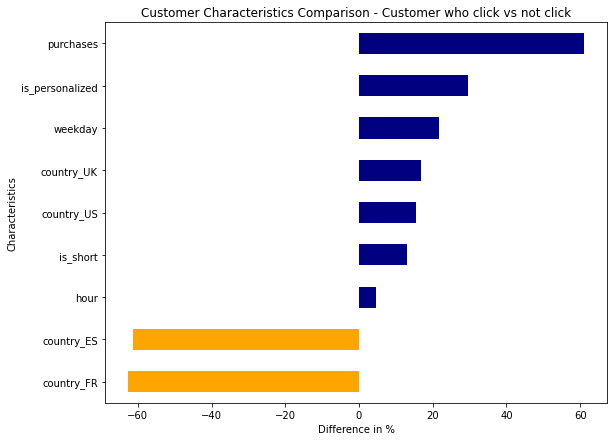

In [18]:
# visualize the differences
plt.figure(figsize = (9, 7))

value1 = pd.DataFrame((((pos.mean()) - neg.mean()) / neg.mean())*100)
value1.dropna(inplace = True)
value1.sort_values(by=0,inplace = True)
value1['positive'] = value1[0] >=0
value1[0].plot(kind='barh', color=value1.positive.map({True: 'navy', False: 'orange'}))
plt.title("Customer Characteristics Comparison - Customer who click vs not click")
plt.xlabel("Difference in %")
plt.ylabel("Characteristics");

In [39]:
# visualize the differences between click and not click
plt.figure(figsize = (9, 7))

value1 = pd.DataFrame((((pos.mean()) - neg.mean()) / neg.mean())*100)
value1.dropna(inplace = True)

value1.sort_values(by=0,inplace = True)
value1

,0
country_FR,-62.729544
country_ES,-61.210624
hour,4.524472
is_short,12.965344
country_US,15.332469
country_UK,16.863780
weekday,21.575695
is_personalized,29.614770
purchases,61.116933
open,1054.801793


<Figure size 648x504 with 0 Axes>

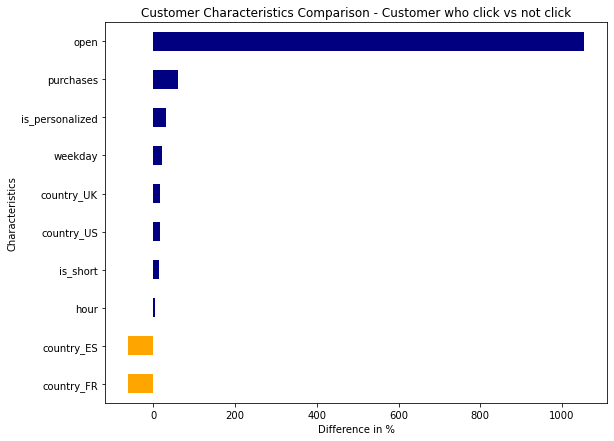

In [43]:
# visualize the differences
plt.figure(figsize = (9, 7))

value1 = pd.DataFrame((((pos.mean()) - neg.mean()) / neg.mean())*100)
value1.dropna(inplace = True)
value1.sort_values(by=0,inplace = True)
value1['positive'] = value1[0] >=0
value1[0].plot(kind='barh', color=value1.positive.map({True: 'navy', False: 'orange'}))
plt.title("Customer Characteristics Comparison - Customer who click vs not click")
plt.xlabel("Difference in %")
plt.ylabel("Characteristics");

In [42]:
from scipy.stats import pearsonr

r1, p_value1  =  pearsonr(x=email['purchases'], y=email['click'])
r2, p_value2  =  pearsonr(x=email['purchases'], y=email['open'])

# print results
print('Pearson correlation of purchases and click is', r1)
print('Pearson p-value: ', p_value1)

print('Pearson correlation of purchases and open is', r2)
print('Pearson p-value: ', p_value2)

Pearson correlation of purchases and click is 0.10544514945599753
Pearson p-value:  3.908892837091622e-245
Pearson correlation of purchases and open is 0.08593391058498803
Pearson p-value:  3.311669811957705e-163


<a id='country'></a>
### Country vs. Customers' reactions

In [237]:
a=pd.get_dummies(z[z['click']==1].drop(columns = 'click')['country']).mean()
b=pd.get_dummies(z[z['click']==0].drop(columns = 'click')['country']).mean()

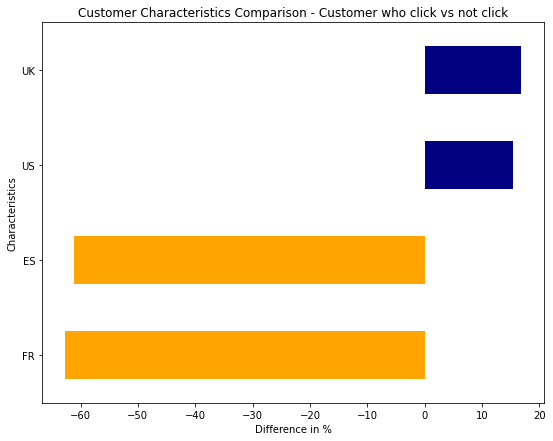

In [238]:
# visualize the differences
plt.figure(figsize = (9, 7))

value1 = pd.DataFrame((a-b)/b*100)
value1.dropna(inplace = True)
value1.sort_values(by=0,inplace = True)
value1['positive'] = value1[0] >=0
value1[0].plot(kind='barh', color=value1.positive.map({True: 'navy', False: 'orange'}))
plt.title("Customer Characteristics Comparison - Customer who click vs not click")
plt.xlabel("Difference in %")
plt.ylabel("Characteristics");

In [58]:
def compar(feature):
    pos = email[email['click']==1][feature].value_counts()
    neg = email[email['click']==0][feature].value_counts()
    value1 = pd.DataFrame(pos/(neg + pos)*100)
    
    plt.figure(figsize = (6, 5))
    value1.dropna(inplace = True)
    value1.sort_values(by=feature,inplace = True)
    value1['positive'] = value1[feature] >=0
    value1[feature].plot(kind='barh', color=value1.positive.map({True: 'navy', False: 'orange'}))
    plt.title("Customer Characteristics Comparison - Customer click the link VS. not click")
    plt.xlabel("Difference in %")
    plt.ylabel("Characteristics")

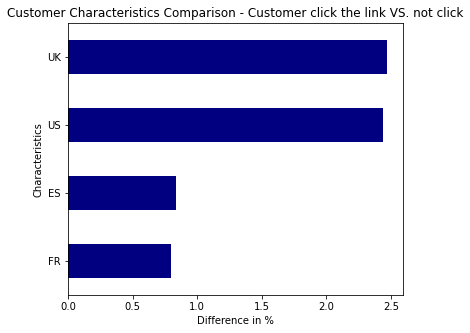

In [62]:
compar('country')

It can be easily found that 'click' percentage are much higher in UK and US than in France and Spain. 

This may be the translation issue. For English-speaking counties, the web are easier to understand. While for those non-English-speaking countries, the emails sent out are not as easy as native language to be readable, which cause low open and click percentages. 

In [138]:
# check the click and open ratio in different countries
click_n = z[z['click']==1].groupby('country')['click'].count()
open_n = z[z['open']==1].groupby('country')['click'].count()
country_n = z.groupby('country')['purchases'].count()

click_open_ratio = click_n / open_n
open_ratio = open_n / country_n

df = pd.DataFrame(click_open_ratio)
df.rename(columns = {'click':'click/open'},inplace=True)
df['open/total'] = open_ratio
df

,click/open,open/total
country,,
ES,0.212821,0.039129
FR,0.197044,0.040620
UK,0.205342,0.120167
US,0.204669,0.119020


Text(0, 0.5, 'Characteristics')

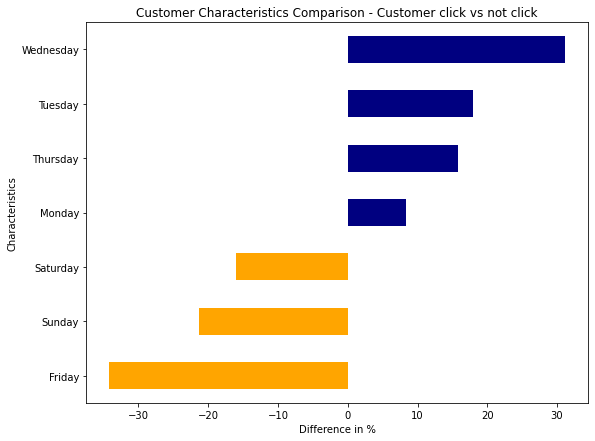

In [92]:
# visualize the differences
plt.figure(figsize = (9, 7))

z= email.copy()
z1_day = z[z['click']==1]['weekday'].value_counts(normalize = True)
z2_day = z[z['click']==0]['weekday'].value_counts(normalize = True)

value1 = pd.DataFrame(((z1_day - z2_day)/ z2_day)*100)
value1.dropna(inplace = True)
value1.sort_values(by="weekday",inplace = True)
value1['positive'] = value1["weekday"] >=0
value1["weekday"].plot(kind='barh', color=value1.positive.map({True: 'navy', False: 'orange'}))
plt.title("Customer Characteristics Comparison - Customer click vs not click")
plt.xlabel("Difference in %")
plt.ylabel("Characteristics")

It can be found from above figure that Fiday, Satuday, Sunday have obviously lower 'open' and 'click' percentage than the other days. 

1. Launch promotion campaign to help those who opened but did not click finish their conversion;

2. Build loyalty program for those who has purchase history;

3. Make the email more personalized;

4. Spend more marketing budge in US and UK; find the reasons why people in ES and FR don’t open the email. 

5. Send emails on Workday instead of weekend, including Friday ;


<a id='build'></a>
## Machine Learning Model
Build a model to predict whether a user will open the email and click the link inside it. Then try to maximize the probability of users clicking on the link by using this model.

<a id='prepare'></a>
#### Prepare the data for ML model

In [182]:
# cope the originial data and create a new one
z = email.copy()
z.head()

,is_short,is_personalized,hour,weekday,country,purchases,open,click
email_id,,,,,,,,
85120,short_email,personalized,2,Sunday,US,5,0,0
966622,long_email,personalized,12,Sunday,UK,2,1,1
777221,long_email,personalized,11,Wednesday,US,2,0,0
493711,short_email,generic,6,Monday,UK,1,0,0
106887,long_email,generic,14,Monday,US,6,0,0


In [183]:
# normalized the purchases since it is continues feature to minimze the size effect
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
z['purchases'] = scaler.fit_transform(z[['purchases']])
z.head()

,is_short,is_personalized,hour,weekday,country,purchases,open,click
email_id,,,,,,,,
85120,short_email,personalized,2,Sunday,US,0.227273,0,0
966622,long_email,personalized,12,Sunday,UK,0.090909,1,1
777221,long_email,personalized,11,Wednesday,US,0.090909,0,0
493711,short_email,generic,6,Monday,UK,0.045455,0,0
106887,long_email,generic,14,Monday,US,0.272727,0,0


In [184]:
# I cut the 24 hours into 4 parts to make it easier to be categoried and analyzed
z["hour"] = pd.cut(email['hour'],bins = [0,9,13,18,24], labels=["morning",'workhour1',"workhour2",'evening'])

# labelencoder the categorical fields inside the table
z['hour'] = LabelEncoder().fit_transform(z['hour'])
z['is_short'] = LabelEncoder().fit_transform(z['is_short'])
z['is_personalized'] = LabelEncoder().fit_transform(z['is_personalized'])
z['weekday'] = LabelEncoder().fit_transform(z['weekday'])
z['weekday'] = (z['weekday']>=4).astype(int)

z = pd.get_dummies(z,columns=['country'])

# define the x and y 
x = z.drop(columns=['click'])
y = (z['click']==1).astype(int)

In [185]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42,stratify=y)
print('Train positive ratio={:.3f}'.format(y_train.mean()))
print('Test positive ratio={:.3f}'.format(y_test.mean()))

Train positive ratio=0.021
Test positive ratio=0.021


It can be found that the split has maintained the same percentage in both training and testing set.

#### Deal with imbalance data by SMOTE and RandomUnderSampler

To better solve the imbalance problem, I will use **SMOTE** to oversampe the minority calss to have 30% the number of examples of the majority class(about 30000), then use **RandomUnderSampler** to reduce the number of examples in the majority class to have 50% more than the minority class(about 49000).

In [186]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 100, max_depth = 8, random_state = 42)
rfc.fit(x_train,y_train)
y_pred = rfc.predict(x_test)

In [187]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

#oversample = SMOTE()
oversample = SMOTE(sampling_strategy = 0.4)
undersample = RandomUnderSampler(sampling_strategy = 0.5)

# chain the two transforms together into a pipeline
steps = [('o', oversample),('u',undersample)]
pipeline = Pipeline(steps = steps)

# transform the dataset
x_train_resample, y_train_resample = pipeline.fit_resample(x_train, y_train)
x_test_resample, y_test_resample = pipeline.fit_resample(x_test, y_test)

print('The original x_train has \033[1m{}\033[0m data, and its corresponding click ratio is \033[1m{}\033[0m.'.format(x_train.shape[0],round(X['click'].sum()/X['click'].count(),2)))
print('The x_train_resample after resampling has \033[1m{}\033[0m data, and the click ratio after resampling is \033[1m{}\033[0m.'.format(x_train_resample.shape[0], round(y_train_resample[y_train_resample == 1].sum() / y_train_resample.shape[0], 2)))

The original x_train has 67000 data, and its corresponding click ratio is 0.02.
The x_train_resample after resampling has 78696 data, and the click ratio after resampling is 0.33.


In [188]:
# define the function to predict the test and get the metric score
def predictions(x_set, y_set, x_test):
    # To avoid the effect of different range of features, I scaled the features firstly.
    # Create the scaler object with a range of 0-1
    #scaler = MinMaxScaler(feature_range=(0, 1))
        
    # Fit on the training data
    #scaler.fit(x_set)

    # Transform both the training and testing data
    #x_set = scaler.transform(x_set)
    #x_test = scaler.transform(x_test)
    
    accuracy, precision, recall, f1, roc_auc, conf_mat = [],[],[],[],[],[]
    
    classifiers = []
    classifiers.append(LogisticRegression(random_state = 42))
    classifiers.append(SVC(random_state=42, probability = True))
    classifiers.append(DecisionTreeClassifier(random_state= 42))
    classifiers.append(RandomForestClassifier(random_state = 42))
    classifiers.append(GradientBoostingClassifier(random_state = 42))   
    
    for classifier in classifiers:       
        clf = classifier
        #fit 
        clf.fit(x_set,y_set)
        # predict
        y_preds = clf.predict(x_test)
        y_probs = clf.predict_proba(x_test)
        #metrics
        accuracy.append(round(accuracy_score(y_test,y_preds),3))
        precision.append(round(precision_score(y_test,y_preds),3))
        recall.append(round(recall_score(y_test,y_preds),3))
        f1.append(round(f1_score(y_test,y_preds),3))
        roc_auc.append(round(roc_auc_score(y_test,y_probs[:,1]),3))
        conf_mat.append(confusion_matrix(y_test,y_preds))      
    
    results_df = pd.DataFrame({"Algorithm":["LogisticRegression","SVC","DecisionTree","RandomForest","GradientBoosting"],"Accuracy Score":accuracy,"Precision Score":precision,
                        "Recall Score":recall, "f1 Score":f1,"Roc-auc Score":roc_auc,
                        "Confusion Matrix":conf_mat})
    results_df = results_df.set_index('Algorithm')
    return results_df

In [189]:
# First calculate the origical data(before resampling)
original_results = predictions(x_train, y_train,x_test)
original_results

C:\Users\xiaoj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Accuracy Score,Precision Score,Recall Score,f1 Score,Roc-auc Score,Confusion Matrix
Algorithm,,,,,,
LogisticRegression,0.979,0.641,0.036,0.068,0.964,"[[32287, 14], [674, 25]]"
SVC,0.979,0.000,0.000,0.000,0.806,"[[32301, 0], [699, 0]]"
DecisionTree,0.978,0.389,0.080,0.133,0.863,"[[32213, 88], [643, 56]]"
RandomForest,0.978,0.374,0.087,0.142,0.923,"[[32199, 102], [638, 61]]"
GradientBoosting,0.979,0.622,0.033,0.063,0.962,"[[32287, 14], [676, 23]]"


In [484]:
# after resampling
resample_results = predictions(x_train_resample,y_train_resample,x_test)
resample_results

,Accuracy Score,Precision Score,Recall Score,f1 Score,Roc-auc Score,Confusion Matrix
Algorithm,,,,,,
LogisticRegression,0.919,0.204,0.980,0.338,0.963,"[[29627, 2674], [14, 685]]"
SVC,0.919,0.204,0.976,0.337,0.954,"[[29637, 2664], [17, 682]]"
DecisionTree,0.945,0.214,0.598,0.316,0.865,"[[30769, 1532], [281, 418]]"
RandomForest,0.943,0.213,0.625,0.318,0.930,"[[30690, 1611], [262, 437]]"
GradientBoosting,0.925,0.217,0.973,0.355,0.960,"[[29845, 2456], [19, 680]]"


#### Imbalanced data and model selections summary:
It can be seen that resampling data showed better recall and F1 scores than original data. 


And among all the models, **Random Forest** showed  higher **f1**, recall, and roc_auc scores, although its accuracy score is not the highest. 


Since in this case, what I really care is if one will click the link, I would firstly select the models with the higher recall and f1 scores to perform the following hyperparameter tuning to obtain the best model.

Text(0.5, 1.0, 'Important Factors of Clicking the Link')

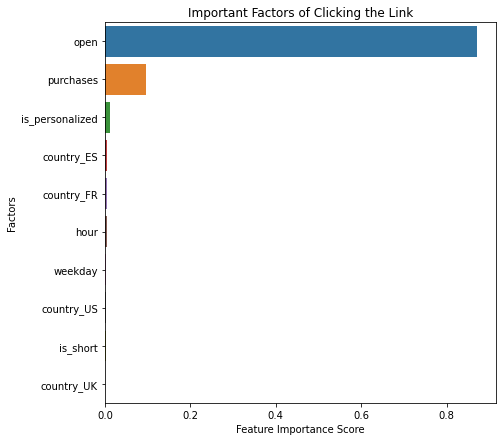

In [190]:
clf = RandomForestClassifier(n_estimators = 100, max_depth = 8, random_state = 42)
clf.fit(x_train_resample,y_train_resample)

feature_imp = pd.Series(clf.feature_importances_, 
        index = list(x_train_resample.columns)).sort_values(ascending=False)


# Creating a bar plot
plt.figure(figsize = (7, 7))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Factors')
plt.title("Important Factors of Clicking the Link")

In [191]:
feature_imp

open               0.871290
purchases          0.096502
is_personalized    0.011029
country_ES         0.004778
country_FR         0.004622
hour               0.003911
weekday            0.003349
country_US         0.001842
is_short           0.001581
country_UK         0.001096
dtype: float64

In [ ]:
import shap

# calculate shap values 
ex = shap.Explainer(clf, x_train_resample)
shap_values = ex(x_test_resample)

# plot
plt.title('SHAP summary for ClickThroughRate', size=16)
shap.plots.beeswarm(shap_values, max_display=8)

 49%|==========          | 38202/77520 [171:04<176:03]       

Train positive ratio=0.103
Test positive ratio=0.103


Text(0.5, 1.0, 'Important Factors of Open the email')

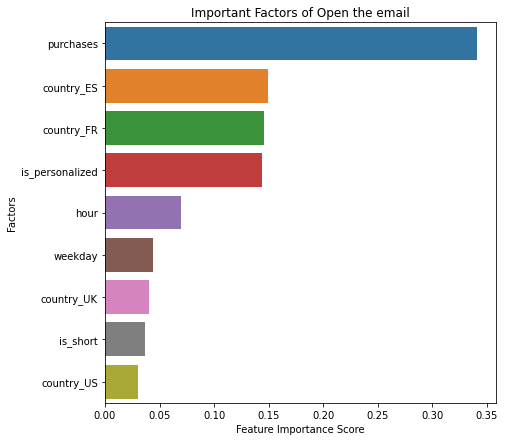

In [203]:
# I cut the 24 hours into 4 parts to make it easier to be categoried and analyzed
z1 = email.copy()
z1["hour"] = pd.cut(email['hour'],bins = [0,9,13,18,24], labels=["morning",'workhour1',"workhour2",'evening'])

# labelencoder the categorical fields inside the table
z1['hour'] = LabelEncoder().fit_transform(z['hour'])
z1['is_short'] = LabelEncoder().fit_transform(z['is_short'])
z1['is_personalized'] = LabelEncoder().fit_transform(z['is_personalized'])
z1['weekday'] = LabelEncoder().fit_transform(z['weekday'])
#z1['weekday'] = (z['weekday']>=4).astype(int)

z1 = pd.get_dummies(z1,columns=['country'])

# define the x and y 
x = z1.drop(columns=['click','open'])
y = (z1['open']==1).astype(int)



x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42,stratify=y)
print('Train positive ratio={:.3f}'.format(y_train.mean()))
print('Test positive ratio={:.3f}'.format(y_test.mean()))


#oversample = SMOTE()
oversample = SMOTE(sampling_strategy = 0.4)
undersample = RandomUnderSampler(sampling_strategy = 0.5)

# chain the two transforms together into a pipeline
steps = [('o', oversample),('u',undersample)]
pipeline = Pipeline(steps = steps)

# transform the dataset
x_train_resample, y_train_resample = pipeline.fit_resample(x_train, y_train)
x_test_resample, y_test_resample = pipeline.fit_resample(x_test, y_test)


clf = RandomForestClassifier(n_estimators = 100, max_depth = 8, random_state = 42)
clf.fit(x_train_resample,y_train_resample)
y_test_resample_pred = clf.predict(x_test_resample)

feature_imp = pd.Series(clf.feature_importances_, 
        index = list(x_train_resample.columns)).sort_values(ascending=False)


# Creating a bar plot
plt.figure(figsize = (7, 7))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Factors')
plt.title("Important Factors of Open the email")

In [204]:
print ("test precision: {:.2f}%".format(precision_score(y_test_resample,y_test_resample_pred) * 100))
print ("test recall: {:.2f}%".format(recall_score(y_test_resample,y_test_resample_pred)* 100 ))

test precision: 58.34%
test recall: 10.40%


In [302]:
old_emails_sent = ytest_pred.shape[0]
new_email_sent = ytest_pred.sum()
saving_percentage = 100 - new_email_sent * 100.0/old_emails_sent

print('Previous emails sent: {:.2f} '.format(old_emails_sent))
print('New emails sent: {:.2f} '.format(new_email_sent))
print('Saving percentage: {:.2f} '.format(saving_percentage))

Previous emails sent: 33000.00 
New emails sent: 8878.00 
Saving percentage: 73.10 


I trained several ML model in previous section which can predict whether a user will click the link or not. The new email campaign strategy will only send email to uses which my model predicts positive.

### How to test if the model can improve click through rate?

A/B test can be performed totest if the model can improve click through rate:
H0: CRT no change; HA: CRT improved
1. Randomly assign users to two groups, control and experimental group.
2. In control group,user still use the old email-campaign strategy,i.e.,just send emails to users randomly.
3. In experiment group,use the model I built to predict whether the user will click the link or not, and only send emails to those users whose predictive result is positive.
4. Calculate sample size and test time
5. Perform a one tail t-test/z-test to test whether experiment group's population proportion is higher than control groups's.
6. Sanity Check and analysis